In [1]:
from polygen.polygen2d import Geometry
from polygen.polygen2d import IO
from polygen.polygen2d import generate_poisson_points, generate_sequence_points
from polygen.polygen2d import lloyd_with_density as lloyd
from polygen.polygen2d import twoPhaseLloyd 
from polygen.polygen2d import VoronoiGenerator, MeshOptimizer, CohesiveZoneAdjuster, VoronoiDiagramForAnsys, rotate_voronoi_diagram
from polygen.polygen2d import plot_boundary_with_points, plot_voronoi_cells, plot_voronoi_edges, plot_voronoi_cells_with_short_edges, plot_triangulated_geometry, plot_error_comparison, plot_boundary_with_short_edges, plot_density_plate_with_hole, plot_density_hexagon, plot_voronoi_cells_with_gaps, create_figure_grid

In [2]:
# Initialize Voronoi generators and optimizers
voronoi_generator = VoronoiGenerator(buffer_factor=1.0)
optimizer = MeshOptimizer(verbose=True)
cohesive_adjuster = CohesiveZoneAdjuster(tolerance=0.005, max_iterations=10, verbose=True)
DPI = 2400

In [3]:
file_path = './examples/CalciteBoundary.obj'
domain = IO.load_polygon_from_file(file_path)

Loaded 1344 polygons from ./examples/CalciteBoundary.obj


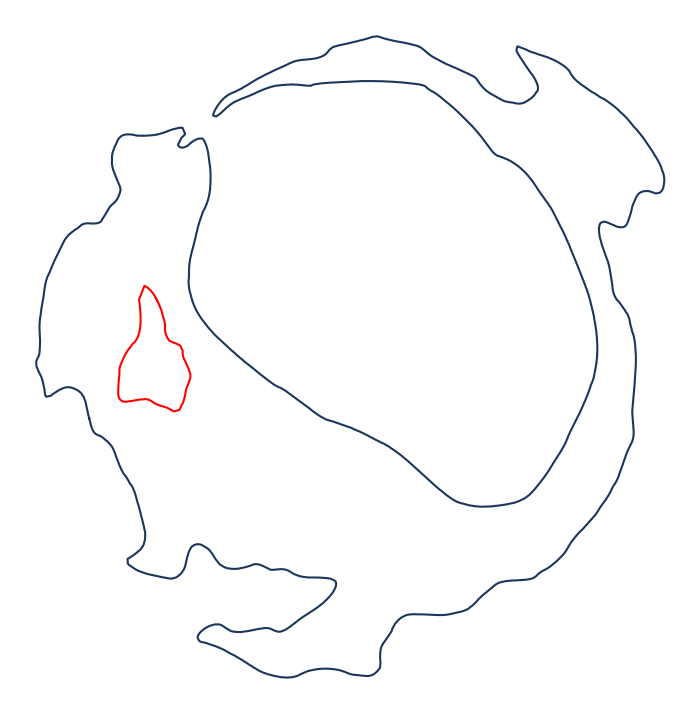

Width: 2019.4873797965402, Height: 2062.157336407911
Area: 1500000.0000000028


In [4]:
from shapely.affinity import scale
def scale_domain_to_reference(domain, reference_domain=None, target_area=1000.0):
    """
    Scale a domain to match a reference domain's area or to a target area.
    
    Parameters
    ----------
    domain : Polygon
        Domain to be scaled
    reference_domain : Polygon, optional
        Reference domain for scaling
    target_area : float, optional
        Target area for scaling if no reference domain is provided
    
    Returns
    -------
    Polygon
        Scaled domain
    """
    # Calculate the target area
    if reference_domain is not None:
        target = reference_domain.area
    else:
        target = target_area
    
    # Calculate scale factor based on area
    scale_factor = (target / domain.area) ** 0.5
    
    # Apply scaling transformation
    domain_centroid = domain.centroid
    scaled_domain = scale(domain, 
                          xfact=scale_factor, 
                          yfact=scale_factor, 
                          origin=domain_centroid)
    
    return scaled_domain

scaled_domain = scale_domain_to_reference(domain, target_area=1.5e6)
plot_boundary_with_points(figure_name='CalciteBoundaryScaled.png', polygon=scaled_domain, dpi=DPI)

minx, miny, maxx, maxy = scaled_domain.bounds
width = maxx - minx
height = maxy - miny
area = scaled_domain.area
print(f"Width: {width}, Height: {height}")
print(f"Area: {area}")

Point generation using quasi-random generator completed in 0.20990 seconds.
Generated 2000 points (target: 2000).


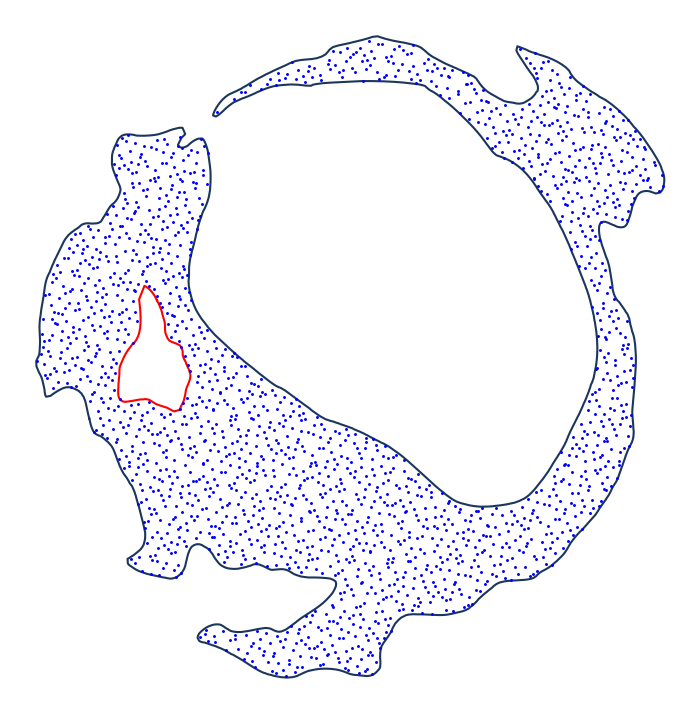

In [5]:
# Initial seed points
N_points = 2000
points_seed = 7845
# poissonPoints = generate_poisson_points(domain=scaled_domain, N=N_points, seed=points_seed, margin=0.05, tolerance=1e-6, max_iterations=100)
sequencePoints = generate_sequence_points(domain=scaled_domain, N=N_points, seed=points_seed, margin=0.05)
plot_boundary_with_points(figure_name='CalciteBoundarywithSequencePoints.png', polygon=scaled_domain, points=sequencePoints, dpi=DPI)

Converged after 39 iterations with error: 4.88058e-03
Total time: 14.18207 seconds


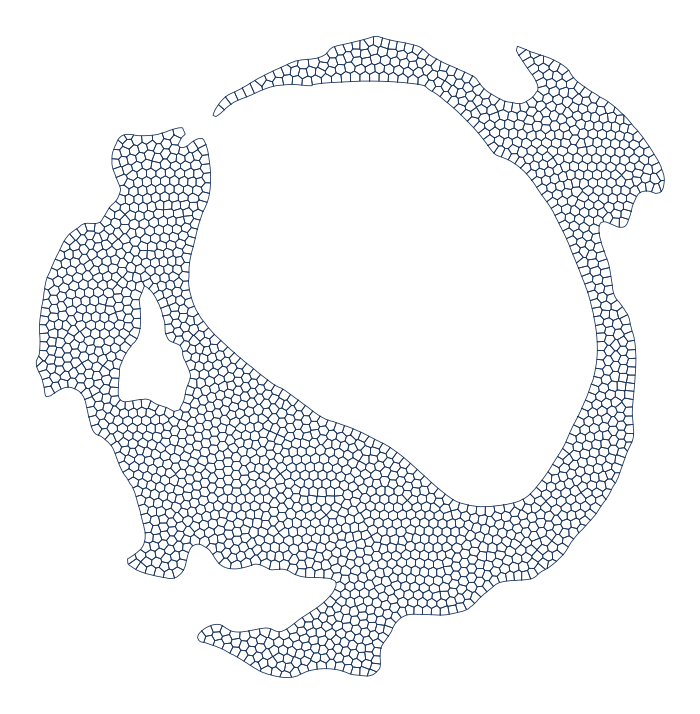

In [6]:
relaxedSequencePointsWithDecay, metrics_relaxedSequencePointsWithDecay = lloyd(polygon=scaled_domain, seed_points=sequencePoints, density_function=None, max_iterations=10000000, tol=5e-3, use_decay=True, grad_increase_tol=10000)

calcite_voronoi = voronoi_generator.generate_cells(domain=scaled_domain, points=relaxedSequencePointsWithDecay)
plot_voronoi_cells(figure_name='calcite_voronoi.png', voronoi_cells=calcite_voronoi, points=None, dpi=DPI, line_width=0.2)

First 50 edge lengths in Voronoi cells:
Edge 0: 0.001531
Edge 1: 0.026136
Edge 2: 0.026365
Edge 3: 0.037420
Edge 4: 0.055431
Edge 5: 0.078507
Edge 6: 0.086621
Edge 7: 0.086621
Edge 8: 0.086974
Edge 9: 0.094395
Edge 10: 0.094591
Edge 11: 0.095920
Edge 12: 0.099234
Edge 13: 0.110226
Edge 14: 0.123816
Edge 15: 0.125720
Edge 16: 0.154003
Edge 17: 0.188022
Edge 18: 0.210475
Edge 19: 0.223848
Edge 20: 0.238370
Edge 21: 0.259969
Edge 22: 0.271551
Edge 23: 0.276186
Edge 24: 0.292626
Edge 25: 0.304539
Edge 26: 0.310540
Edge 27: 0.330796
Edge 28: 0.351250
Edge 29: 0.353728
Edge 30: 0.368078
Edge 31: 0.375151
Edge 32: 0.376621
Edge 33: 0.381055
Edge 34: 0.388264
Edge 35: 0.388264
Edge 36: 0.393865
Edge 37: 0.393865
Edge 38: 0.398528
Edge 39: 0.398528
Edge 40: 0.401784
Edge 41: 0.401784
Edge 42: 0.411079
Edge 43: 0.411079
Edge 44: 0.444893
Edge 45: 0.444893
Edge 46: 0.446834
Edge 47: 0.465186
Edge 48: 0.475192
Edge 49: 0.477637


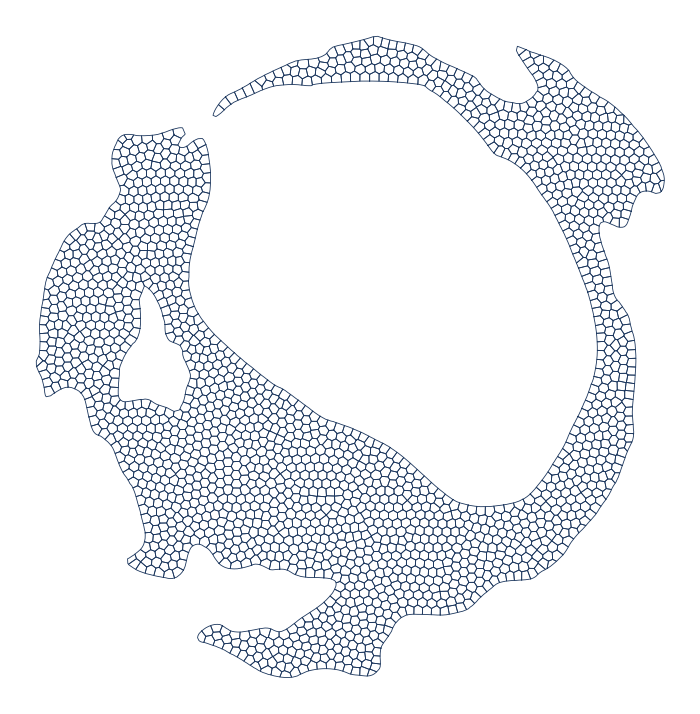

In [7]:
optimizer.analyze_voronoi_edges(voronoi_cells=calcite_voronoi, n=50)
# plot_voronoi_cells_with_short_edges(figure_name='calcite_voronoi_short_edges.png', voronoi_cells=calcite_voronoi, points=None, dpi=DPI, cell_width=0.2, short_edge_width=0.3, threshold=0.02)
optimized_calciteVoronoi = optimizer.optimize_voronoi_cells(voronoi_cells=calcite_voronoi, threshold=0.02)
plot_voronoi_cells(figure_name='optimized_calciteVoronoi.png', voronoi_cells=optimized_calciteVoronoi, dpi=DPI, line_width=0.2)

### Implementing PolyMesher

It:   1   Error: 1.830e-01
It:   2   Error: 7.605e-02
It:   3   Error: 4.897e-02
It:   4   Error: 3.648e-02
It:   5   Error: 2.967e-02
It:   6   Error: 2.472e-02
It:   7   Error: 2.138e-02
It:   8   Error: 1.904e-02
It:   9   Error: 1.713e-02
It:  10   Error: 1.617e-02
It:  11   Error: 1.501e-02
It:  12   Error: 1.385e-02
It:  13   Error: 1.291e-02
It:  14   Error: 1.216e-02
It:  15   Error: 1.270e-02
It:  16   Error: 1.168e-02
It:  17   Error: 1.073e-02
It:  18   Error: 1.024e-02
It:  19   Error: 9.418e-03
It:  20   Error: 9.560e-03
It:  21   Error: 8.953e-03
It:  22   Error: 8.216e-03
It:  23   Error: 7.942e-03
It:  24   Error: 7.659e-03
It:  25   Error: 8.011e-03
It:  26   Error: 7.781e-03
It:  27   Error: 7.558e-03
It:  28   Error: 8.046e-03
It:  29   Error: 6.514e-03
It:  30   Error: 6.113e-03
It:  31   Error: 6.388e-03
It:  32   Error: 5.704e-03
It:  33   Error: 6.080e-03
It:  34   Error: 5.779e-03
It:  35   Error: 6.597e-03
It:  36   Error: 5.720e-03
It:  37   Error: 5.320e-03
I

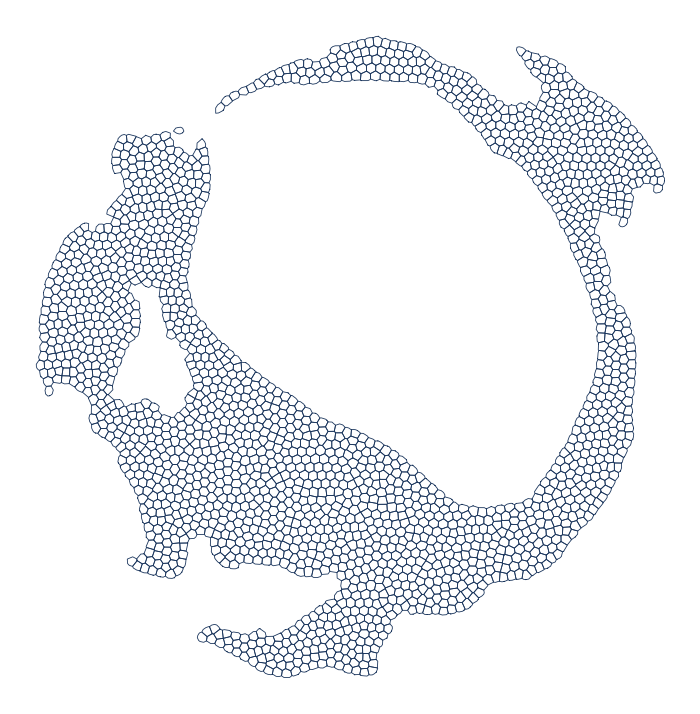

In [8]:
from importlib import reload
import lloydPolymesher, voronoiPolymesher
reload(lloydPolymesher)
reload(voronoiPolymesher) 
from lloydPolymesher import polymesher_lloyd
from voronoiPolymesher import PolyMesherVoronoiGenerator

relaxedPolymesher, _ = polymesher_lloyd(polygon=scaled_domain, seed_points=sequencePoints, density_function=None, max_iterations=100000000, tol=5e-3)

# Initialize the PolyMesher-style generator
polymesher_generator = PolyMesherVoronoiGenerator(reflection_factor=1.5)
# Generate cells using the same interface
polymesher_voronoi = polymesher_generator.generate_cells(domain=scaled_domain, points=relaxedPolymesher)
plot_voronoi_cells(figure_name='calcite_PolyMesherVoronoi.png', voronoi_cells=polymesher_voronoi, points=None, dpi=DPI, line_width=0.2)

In [9]:
optimizer.analyze_voronoi_edges(voronoi_cells=polymesher_voronoi, n=50)
# optimized_calcitePolyMesherVoronoi = optimizer.optimize_voronoi_cells(voronoi_cells=polymesher_voronoi, threshold=200)
# plot_voronoi_cells(figure_name='optimized_calcitePolyMesherVoronoi.png', voronoi_cells=optimized_calcitePolyMesherVoronoi, dpi=DPI, line_width=0.2)

First 50 edge lengths in Voronoi cells:
Edge 0: 0.004156
Edge 1: 0.018456
Edge 2: 0.020345
Edge 3: 0.021872
Edge 4: 0.022806
Edge 5: 0.025468
Edge 6: 0.035806
Edge 7: 0.039788
Edge 8: 0.045932
Edge 9: 0.057470
Edge 10: 0.083416
Edge 11: 0.083951
Edge 12: 0.083951
Edge 13: 0.087079
Edge 14: 0.087079
Edge 15: 0.087283
Edge 16: 0.119012
Edge 17: 0.124522
Edge 18: 0.145888
Edge 19: 0.149041
Edge 20: 0.149041
Edge 21: 0.168260
Edge 22: 0.170242
Edge 23: 0.172166
Edge 24: 0.173163
Edge 25: 0.184079
Edge 26: 0.188735
Edge 27: 0.195020
Edge 28: 0.195432
Edge 29: 0.195432
Edge 30: 0.206793
Edge 31: 0.231991
Edge 32: 0.241584
Edge 33: 0.245424
Edge 34: 0.253127
Edge 35: 0.266279
Edge 36: 0.285692
Edge 37: 0.290252
Edge 38: 0.290698
Edge 39: 0.292545
Edge 40: 0.301014
Edge 41: 0.307829
Edge 42: 0.310360
Edge 43: 0.314931
Edge 44: 0.314931
Edge 45: 0.322364
Edge 46: 0.332188
Edge 47: 0.342351
Edge 48: 0.345922
Edge 49: 0.354668


In [10]:
import os
import numpy as np
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, MultiPolygon, LineString, Point
from typing import Union, Dict, List

def get_figure_size(layout='single', journal_type='large'):
    """
    Calculate figure size in inches based on journal specifications.
    
    Parameters
    ----------
    layout : str
        Layout type ('single', '1x2', '1x3', '2x2', '2x3', '3x2', '3x3').
    journal_type : str
        Journal size ('large' or 'small').
    
    Returns
    -------
    tuple
        Figure size in inches (width, height).
    """
    mm_to_inches = 1 / 25.4  # Conversion factor from mm to inches

    # Journal-specific dimensions
    if journal_type == 'large':
        single_column = 84 * mm_to_inches  # 84 mm width for single column
        double_column = 174 * mm_to_inches  # 174 mm width for double column
        max_height = 234 * mm_to_inches  # Max height: 234 mm
    elif journal_type == 'small':
        single_column = 119 * mm_to_inches  # 119 mm width for single column
        double_column = 119 * mm_to_inches  # Use single-column width for all
        max_height = 195 * mm_to_inches  # Max height: 195 mm
    else:
        raise ValueError("journal_type must be 'large' or 'small'.")

    # Aspect ratio constants
    aspect_ratios = {
        'single': (4, 3),  # Standard 4:3 for single plot
        '1x2': (8, 3),     # Wider for 1x2 (16:6 or 8:3)
        '1x3': (12, 3),    # Very wide for 1x3
        '2x2': (4, 4),     # Square for 2x2
        '2x3': (6, 4),     # Moderate height for 2x3
        '3x2': (4, 6),     # Taller for 3x2
        '3x3': (4, 4)      # Square for 3x3
    }

    # Get aspect ratio for the layout
    ratio = aspect_ratios.get(layout, aspect_ratios['single'])
    width, height = ratio

    # Scale width and height to fit the journal's column width
    if layout == 'single':
        width = single_column
    else:
        width = double_column
    height = (width / ratio[0]) * ratio[1]

    # Ensure height doesn't exceed maximum allowed
    height = min(height, max_height)
    return (width, height)
 
def set_publication_style():
    """
    Configure matplotlib for publication-quality figures following journal guidelines.
    
    Key requirements implemented:
    - Vector graphics (saved as EPS)
    - Helvetica/Arial font
    - Consistent font sizing (8-12pt)
    - Minimum line width 0.3pt
    - No titles within figures
    - Proper figure dimensions
    """
    plt.style.use('default')
    
    params = {
        # Font settings
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],  # As per guidelines
        'text.usetex': False,  # Disable LaTeX to ensure font consistency
        
        # Font sizes (8-12pt as specified)
        'font.size': 10,
        'axes.labelsize': 10,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # Line widths (minimum 0.3pt = 0.1mm)
        'axes.linewidth': 0.3,
        'grid.linewidth': 0.3,
        'lines.linewidth': 0.3,
        'xtick.major.width': 0.3,
        'ytick.major.width': 0.3,
        
        # Figure settings
        'figure.dpi': 300,        # For line art
        'savefig.dpi': 1200,      # For line art
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1,
        
        # Other settings
        'figure.figsize': [3.3, 2.0],  # 84mm width (single column) at 72 dpi
        'figure.autolayout': True
    }
    plt.rcParams.update(params)

def plot_boundary_comparison(
    domain,
    polygen_cells,
    polymesher_cells,
    figure_name,
    show_figure=True,
    domain_color='#1B365D',
    domain_style='-',
    polygen_color='#008080',  # Teal
    polymesher_color='#B22222',  # Firebrick
    cell_style='-',
    line_width=0.5,
    highlight_outside=True,
    outside_alpha=0.3,
    outside_color='#B22222',  # Firebrick
    zoom_regions=None,
    margins=0.01,
    dpi=1200,
    show_axes=False,
    output_dir='Plots'
):
    """
    Create a side-by-side comparison of boundary elements between PolyGen and PolyMesher.
    
    Parameters
    ----------
    domain : shapely.geometry.Polygon
        The domain boundary
    polygen_cells : list
        List of PolyGen Voronoi cell polygons
    polymesher_cells : list
        List of PolyMesher Voronoi cell polygons
    figure_name : str
        Name of the output figure
    show_figure : bool, optional
        Whether to display the figure, by default True
    domain_color : str, optional
        Color for domain boundary, by default '#1B365D'
    domain_style : str, optional
        Line style for domain boundary, by default '-'
    polygen_color : str, optional
        Color for PolyGen cells, by default '#008080'
    polymesher_color : str, optional
        Color for PolyMesher cells, by default '#B22222'
    cell_style : str, optional
        Line style for cells, by default '-'
    line_width : float, optional
        Width of boundary lines, by default 0.5
    highlight_outside : bool, optional
        Whether to highlight areas that extend beyond the domain, by default True
    outside_alpha : float, optional
        Transparency for highlighted outside areas, by default 0.3
    outside_color : str, optional
        Color for highlighted outside areas, by default '#B22222'
    zoom_regions : list of tuples, optional
        List of regions to zoom in on, specified as (x_min, y_min, x_max, y_max)
    margins : float or tuple, optional
        Margins around the plot, by default 0.01
    dpi : int, optional
        Resolution of saved figure, by default 1200
    show_axes : bool, optional
        Whether to show axes and ticks, by default False
    output_dir : str, optional
        Directory to save the figure, by default 'Plots'
        
    Notes
    -----
    This function creates a side-by-side comparison showing how PolyGen and
    PolyMesher handle domain boundaries differently. It specifically highlights
    areas where PolyMesher cells extend beyond the domain boundary.
    """
    from matplotlib.patches import Patch
    from shapely.ops import unary_union
    
    # Input validation
    valid_line_styles = ['-', '--', '-.', ':']
    if domain_style not in valid_line_styles or cell_style not in valid_line_styles:
        raise ValueError(f"Line styles must be one of: {valid_line_styles}")
    
    # Setup
    set_publication_style()
    
    # Create figure with two subplots side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=get_figure_size(layout='1x2', journal_type='large'))
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    
    # Set margins
    if isinstance(margins, (int, float)):
        ax1.margins(margins)
        ax2.margins(margins)
    else:
        ax1.margins(x=margins[0], y=margins[1])
        ax2.margins(x=margins[0], y=margins[1])
    
    # Find boundary cells
    polygen_boundary_cells = []
    polymesher_boundary_cells = []
    domain_boundary = domain.boundary
    
    for cell in polygen_cells:
        if cell.intersects(domain_boundary):
            polygen_boundary_cells.append(cell)
    
    for cell in polymesher_cells:
        if cell.intersects(domain_boundary):
            polymesher_boundary_cells.append(cell)
    
    # Plot domain boundary on both subplots
    x, y = domain.exterior.xy
    ax1.plot(x, y, color=domain_color, linestyle=domain_style, linewidth=line_width*1.5, label='Domain')
    ax2.plot(x, y, color=domain_color, linestyle=domain_style, linewidth=line_width*1.5, label='Domain')
    
    # Plot boundary cells on each subplot
    for cell in polygen_boundary_cells:
        x, y = cell.exterior.xy
        ax1.plot(x, y, color=polygen_color, linestyle=cell_style, linewidth=line_width)
    
    for cell in polymesher_boundary_cells:
        x, y = cell.exterior.xy
        ax2.plot(x, y, color=polymesher_color, linestyle=cell_style, linewidth=line_width)
    
    # Highlight areas outside domain for PolyMesher
    if highlight_outside:
        for cell in polymesher_boundary_cells:
            # Find the part of the cell that's outside the domain
            outside_part = cell.difference(domain)
            if not outside_part.is_empty:
                if isinstance(outside_part, Polygon):
                    x, y = outside_part.exterior.xy
                    ax2.fill(x, y, color=outside_color, alpha=outside_alpha)
                elif hasattr(outside_part, 'geoms'):
                    for geom in outside_part.geoms:
                        if isinstance(geom, Polygon):
                            x, y = geom.exterior.xy
                            ax2.fill(x, y, color=outside_color, alpha=outside_alpha)
    
    # Set titles
    ax1.set_title('PolyGen (Clipping)', fontsize=10)
    ax2.set_title('PolyMesher (Reflection)', fontsize=10)
    
    # Create legend items
    legend_elements = [
        Patch(facecolor='none', edgecolor=domain_color, label='Domain'),
        Patch(facecolor='none', edgecolor=polygen_color, label='PolyGen Cells')
    ]
    
    polymesher_patch = Patch(facecolor='none', edgecolor=polymesher_color, label='PolyMesher Cells')
    legend_elements.append(polymesher_patch)
    
    if highlight_outside:
        outside_patch = Patch(facecolor=outside_color, alpha=outside_alpha, 
                            edgecolor='none', label='Outside Domain')
        legend_elements.append(outside_patch)
    
    # Add the legend to the figure
    fig.legend(handles=legend_elements, loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.05))
    
    # If zoom regions are provided, create inset axes
    if zoom_regions:
        from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
        
        for i, region in enumerate(zoom_regions):
            x_min, y_min, x_max, y_max = region
            
            # Create zoomed inset for PolyGen
            axins1 = zoomed_inset_axes(ax1, zoom=4, loc='upper left')
            axins1.set_xlim(x_min, x_max)
            axins1.set_ylim(y_min, y_max)
            axins1.set_xticklabels([])
            axins1.set_yticklabels([])
            
            # Plot domain and cells in inset
            x, y = domain.exterior.xy
            axins1.plot(x, y, color=domain_color, linestyle=domain_style, linewidth=line_width*1.5)
            
            for cell in polygen_boundary_cells:
                x, y = cell.exterior.xy
                axins1.plot(x, y, color=polygen_color, linestyle=cell_style, linewidth=line_width)
            
            mark_inset(ax1, axins1, loc1=2, loc2=4, fc="none", ec="0.5")
            
            # Create zoomed inset for PolyMesher
            axins2 = zoomed_inset_axes(ax2, zoom=4, loc='upper left')
            axins2.set_xlim(x_min, x_max)
            axins2.set_ylim(y_min, y_max)
            axins2.set_xticklabels([])
            axins2.set_yticklabels([])
            
            # Plot domain and cells in inset
            x, y = domain.exterior.xy
            axins2.plot(x, y, color=domain_color, linestyle=domain_style, linewidth=line_width*1.5)
            
            for cell in polymesher_boundary_cells:
                x, y = cell.exterior.xy
                axins2.plot(x, y, color=polymesher_color, linestyle=cell_style, linewidth=line_width)
                
                # Highlight outside areas in inset
                if highlight_outside:
                    outside_part = cell.difference(domain)
                    if not outside_part.is_empty:
                        if isinstance(outside_part, Polygon):
                            x, y = outside_part.exterior.xy
                            axins2.fill(x, y, color=outside_color, alpha=outside_alpha)
                        elif hasattr(outside_part, 'geoms'):
                            for geom in outside_part.geoms:
                                if isinstance(geom, Polygon):
                                    x, y = geom.exterior.xy
                                    axins2.fill(x, y, color=outside_color, alpha=outside_alpha)
            
            mark_inset(ax2, axins2, loc1=2, loc2=4, fc="none", ec="0.5")
    
    # Handle axes visibility
    if not show_axes:
        ax1.axis('off')
        ax2.axis('off')
    
    plt.tight_layout()
    
    # Adjust layout to make room for the legend
    plt.subplots_adjust(bottom=0.15)
    
    # Handle figure saving
    os.makedirs(output_dir, exist_ok=True)
    base_name, ext = os.path.splitext(figure_name)
    ext = ext if ext else ".png"
    
    plt.savefig(
        f'{output_dir}/{base_name}{ext}',
        dpi=dpi,
        bbox_inches='tight',
        pad_inches=0.05
    )
    
    if show_figure:
        plt.show()
    
    plt.close()

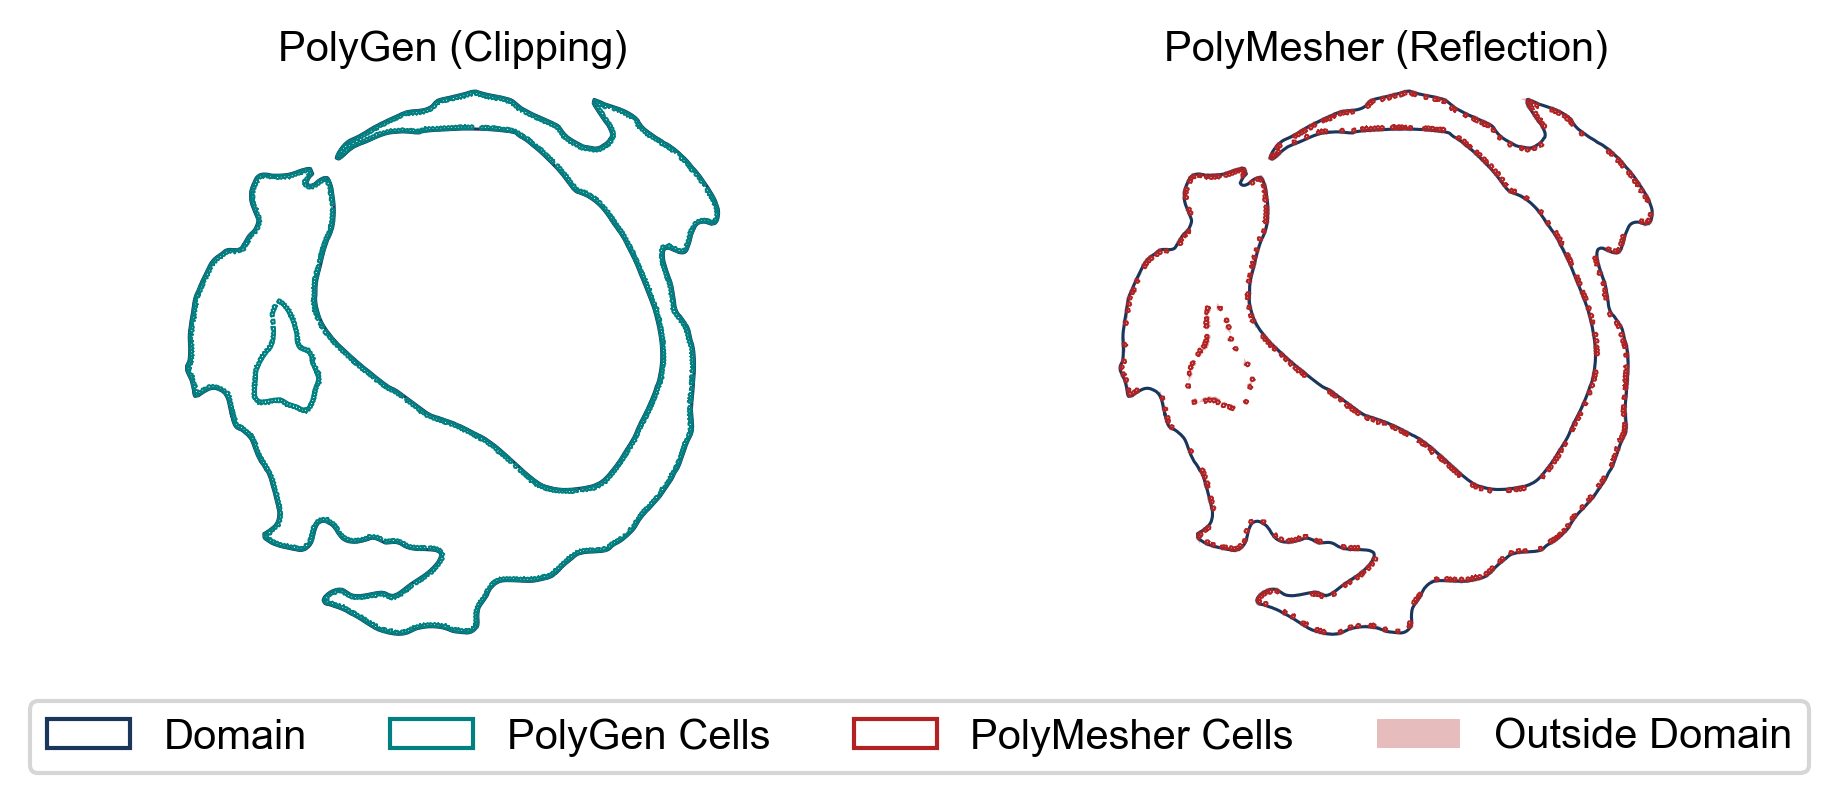

In [39]:
# Example usage
plot_boundary_comparison(
    domain=scaled_domain,
    polygen_cells=optimized_calciteVoronoi,
    polymesher_cells=polymesher_voronoi,
    figure_name="boundary_comparison.png",
    zoom_regions=None,  # Example region - adjust to your domain
    output_dir="quality_comparison_results"
)

In [11]:
from polygen.polygen2d.extractVoronoiEdges import VoronoiEdgeExtractor
def get_figure_size(layout='single', journal_type='large'):
    """
    Calculate figure size in inches based on journal specifications.
    
    Parameters
    ----------
    layout : str
        Layout type ('single', '1x2', '1x3', '2x2', '2x3', '3x2', '3x3').
    journal_type : str
        Journal size ('large' or 'small').
    
    Returns
    -------
    tuple
        Figure size in inches (width, height).
    """
    mm_to_inches = 1 / 25.4  # Conversion factor from mm to inches

    # Journal-specific dimensions
    if journal_type == 'large':
        single_column = 84 * mm_to_inches  # 84 mm width for single column
        double_column = 174 * mm_to_inches  # 174 mm width for double column
        max_height = 234 * mm_to_inches  # Max height: 234 mm
    elif journal_type == 'small':
        single_column = 119 * mm_to_inches  # 119 mm width for single column
        double_column = 119 * mm_to_inches  # Use single-column width for all
        max_height = 195 * mm_to_inches  # Max height: 195 mm
    else:
        raise ValueError("journal_type must be 'large' or 'small'.")

    # Aspect ratio constants
    aspect_ratios = {
        'single': (4, 3),  # Standard 4:3 for single plot
        '1x2': (10, 6),     # Wider for 1x2 (16:6 or 8:3)
        '1x3': (12, 3),    # Very wide for 1x3
        '2x2': (4, 4),     # Square for 2x2
        '2x3': (6, 4),     # Moderate height for 2x3
        '3x2': (4, 6),     # Taller for 3x2
        '3x3': (4, 4)      # Square for 3x3
    }

    # Get aspect ratio for the layout
    ratio = aspect_ratios.get(layout, aspect_ratios['single'])
    width, height = ratio

    # Scale width and height to fit the journal's column width
    if layout == 'single':
        width = single_column
    else:
        width = double_column
    height = (width / ratio[0]) * ratio[1]

    # Ensure height doesn't exceed maximum allowed
    height = min(height, max_height)
    return (width, height)
 
def set_publication_style():
    """
    Configure matplotlib for publication-quality figures following journal guidelines.
    
    Key requirements implemented:
    - Vector graphics (saved as EPS)
    - Helvetica/Arial font
    - Consistent font sizing (8-12pt)
    - Minimum line width 0.3pt
    - No titles within figures
    - Proper figure dimensions
    """
    plt.style.use('default')
    
    params = {
        # Font settings
        'font.family': 'sans-serif',
        'font.sans-serif': ['Arial', 'Helvetica'],  # As per guidelines
        'text.usetex': False,  # Disable LaTeX to ensure font consistency
        
        # Font sizes (8-12pt as specified)
        'font.size': 10,
        'axes.labelsize': 10,
        'xtick.labelsize': 10,
        'ytick.labelsize': 10,
        'legend.fontsize': 10,
        
        # Line widths (minimum 0.3pt = 0.1mm)
        'axes.linewidth': 0.3,
        'grid.linewidth': 0.3,
        'lines.linewidth': 0.3,
        'xtick.major.width': 0.3,
        'ytick.major.width': 0.3,
        
        # Figure settings
        'figure.dpi': 300,        # For line art
        'savefig.dpi': 1200,      # For line art
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1,
        
        # Other settings
        'figure.figsize': [3.3, 2.0],  # 84mm width (single column) at 72 dpi
        'figure.autolayout': True
    }
    plt.rcParams.update(params)

def plot_boundary_comparison(
    domain,
    polygen_cells,
    polymesher_cells,
    figure_name,
    show_figure=True,
    domain_color='#555555',
    domain_style='--',
    cell_boundary_color='#1B365D',
    cell_boundary_style='-',
    plot_all_cells=False,
    cell_internal_color='#AAAAAA',
    cell_internal_style='-',
    fill_outside=True,
    outside_color='#B22222',
    outside_alpha=0.2,
    highlight_regions=None,
    domain_line_width=0.8,
    cell_boundary_line_width=0.5,
    cell_internal_line_width=0.2,
    margins=0.01,
    dpi=1200,
    show_axes=False,
    output_dir='Plots'
):
    """
    Create a side-by-side comparison showing how PolyGen and PolyMesher approximate domain boundaries.
    
    Parameters
    ----------
    domain : shapely.geometry.Polygon
        The domain boundary to be approximated
    polygen_cells : list
        List of shapely.geometry.Polygon objects representing PolyGen Voronoi cells
    polymesher_cells : list
        List of shapely.geometry.Polygon objects representing PolyMesher Voronoi cells
    figure_name : str
        Name of the output figure. If no extension is provided, '.png' is used.
    show_figure : bool, optional
        Whether to display the figure, by default True
    domain_color : str, optional
        Color for domain boundary, by default '#555555' (gray)
    domain_style : str, optional
        Line style for domain boundary, by default '--' (dashed)
    cell_boundary_color : str, optional
        Color for Voronoi cell boundaries, by default '#1B365D' (dark blue)
    cell_boundary_style : str, optional
        Line style for cell boundaries, by default '-' (solid)
    plot_all_cells : bool, optional
        Whether to plot all Voronoi cell edges, including internal edges, by default False
    cell_internal_color : str, optional
        Color for non-boundary cell edges if plot_all_cells is True, by default '#AAAAAA' (light gray)
    cell_internal_style : str, optional
        Line style for non-boundary cell edges, by default '-' (solid)
    fill_outside : bool, optional
        Whether to highlight areas outside the domain with color, by default True
    outside_color : str, optional
        Color for areas outside the domain, by default '#B22222' (firebrick red)
    outside_alpha : float, optional
        Transparency for outside areas, by default 0.2
    highlight_regions : list of tuples, optional
        List of regions to highlight with a box, specified as (x_min, y_min, x_max, y_max)
    domain_line_width : float, optional
        Width of domain boundary lines, by default 0.8
    cell_boundary_line_width : float, optional
        Width of cell boundary lines, by default 0.5
    cell_internal_line_width : float, optional
        Width of internal cell edge lines, by default 0.2
    margins : float or tuple, optional
        Margins around the plot, by default 0.01
    dpi : int, optional
        Resolution of saved figure in dots per inch, by default 1200
    show_axes : bool, optional
        Whether to show axes and ticks, by default False
    output_dir : str, optional
        Directory to save the figure, by default 'Plots'
        
    Notes
    -----
    This function creates a side-by-side comparison showing how PolyGen and PolyMesher
    approximate domain boundaries. Domain boundaries are shown with dashed lines, while
    the boundaries of Voronoi cells are shown with solid lines. Areas where PolyMesher
    cells extend beyond the domain are highlighted with color.
    
    The function extracts boundary edges from both cell sets using the VoronoiEdgeExtractor
    to clearly show boundary approximation, and optionally plots all cell edges.
    """
    from matplotlib.patches import Rectangle, Patch
    from shapely.ops import unary_union
    
    # Input validation
    valid_line_styles = ['-', '--', '-.', ':']
    for style in [domain_style, cell_boundary_style, cell_internal_style]:
        if style not in valid_line_styles:
            raise ValueError(f"Line styles must be one of: {valid_line_styles}")
    
    # Setup
    set_publication_style()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=get_figure_size(layout='1x2', journal_type='large'))
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    
    # Set margins
    if isinstance(margins, (int, float)):
        ax1.margins(margins)
        ax2.margins(margins)
    else:
        ax1.margins(x=margins[0], y=margins[1])
        ax2.margins(x=margins[0], y=margins[1])
    
    # Extract boundary edges using VoronoiEdgeExtractor
    extractor = VoronoiEdgeExtractor(use_kdtree=True)
    
    # Extract PolyGen edges
    polygen_boundary_edges, polygen_internal_edges = extractor.extract_edges(modified_cells=polygen_cells)
    
    # Extract PolyMesher edges
    polymesher_boundary_edges, polymesher_internal_edges = extractor.extract_edges(modified_cells=polymesher_cells)
    
    # Plot all cell edges if requested
    if plot_all_cells:
        # Plot internal edges for PolyGen
        for edge in polygen_internal_edges:
            ax1.plot(*edge.xy, color=cell_internal_color, linestyle=cell_internal_style, 
                     linewidth=cell_internal_line_width, zorder=1)
        
        # Plot internal edges for PolyMesher
        for edge in polymesher_internal_edges:
            ax2.plot(*edge.xy, color=cell_internal_color, linestyle=cell_internal_style, 
                     linewidth=cell_internal_line_width, zorder=1)
    
    # Plot cell boundary edges
    for edge in polygen_boundary_edges:
        ax1.plot(*edge.xy, color=cell_boundary_color, linestyle=cell_boundary_style, 
                 linewidth=cell_boundary_line_width, zorder=3)
    
    for edge in polymesher_boundary_edges:
        ax2.plot(*edge.xy, color=cell_boundary_color, linestyle=cell_boundary_style, 
                 linewidth=cell_boundary_line_width, zorder=3)
    
    # Highlight areas outside the domain for PolyMesher if requested
    if fill_outside:
        # Create a union of all PolyMesher cells
        polymesher_union = unary_union(polymesher_cells)
        
        # Find the difference between the union and the domain
        outside_area = polymesher_union.difference(domain)
        
        if not outside_area.is_empty:
            if hasattr(outside_area, 'geoms'):  # MultiPolygon or other multi-geometry
                for geom in outside_area.geoms:
                    if isinstance(geom, Polygon):
                        x, y = geom.exterior.xy
                        ax2.fill(x, y, color=outside_color, alpha=outside_alpha, zorder=2)
            else:  # Single Polygon
                x, y = outside_area.exterior.xy
                ax2.fill(x, y, color=outside_color, alpha=outside_alpha, zorder=2)
    
    # Plot domain boundary on both subplots (after the fill to ensure it's visible)
    x, y = domain.exterior.xy
    ax1.plot(x, y, color=domain_color, linestyle=domain_style, linewidth=domain_line_width, zorder=4)
    ax2.plot(x, y, color=domain_color, linestyle=domain_style, linewidth=domain_line_width, zorder=4)
    
    # Plot interior boundaries if present
    for interior in domain.interiors:
        x, y = interior.xy
        ax1.plot(x, y, color=domain_color, linestyle=domain_style, linewidth=domain_line_width, zorder=4)
        ax2.plot(x, y, color=domain_color, linestyle=domain_style, linewidth=domain_line_width, zorder=4)
    
    # Add highlight boxes if specified
    if highlight_regions:
        for i, region in enumerate(highlight_regions):
            x_min, y_min, x_max, y_max = region
            width = x_max - x_min
            height = y_max - y_min
            
            # Add highlight box to PolyGen plot
            rect1 = Rectangle((x_min, y_min), width, height, 
                             fill=False, edgecolor='green', 
                             linestyle='-', linewidth=0.8, zorder=5)
            ax1.add_patch(rect1)
            
            # Add highlight box to PolyMesher plot
            rect2 = Rectangle((x_min, y_min), width, height, 
                             fill=False, edgecolor='green', 
                             linestyle='-', linewidth=0.8, zorder=5)
            ax2.add_patch(rect2)
    
    # Set titles
    ax1.set_title('PolyGen (clipping)', fontsize=10)
    ax2.set_title('PolyMesher (reflection)', fontsize=10)
    
    # Create legend
    legend_elements = [
        Patch(facecolor='none', edgecolor=domain_color, linestyle=domain_style, 
              label='Domain boundary')
    ]
    
    legend_elements.append(
        Patch(facecolor='none', edgecolor=cell_boundary_color, linestyle=cell_boundary_style, 
              label='Cell boundary')
    )
    
    if plot_all_cells:
        legend_elements.append(
            Patch(facecolor='none', edgecolor=cell_internal_color, linestyle=cell_internal_style, 
                  label='Cell internal edge')
        )
    
    if fill_outside:
        legend_elements.append(
            Patch(facecolor=outside_color, alpha=outside_alpha, edgecolor='none', 
                  label='Outside domain')
        )
    
    # Add legend to figure (shared between subplots)
    fig.legend(handles=legend_elements, loc='lower center', ncol=len(legend_elements), 
               bbox_to_anchor=(0.5, 0.01), frameon=False)
    
    # Handle axes visibility
    if not show_axes:
        ax1.axis('off')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)  # Make room for the legend
    
    # Handle figure saving
    os.makedirs(output_dir, exist_ok=True)
    base_name, ext = os.path.splitext(figure_name)
    ext = ext if ext else '.png'
    
    plt.savefig(
        f'{output_dir}/{base_name}{ext}',
        dpi=dpi,
        bbox_inches='tight',
        pad_inches=0.05
    )
    
    if show_figure:
        plt.show()
    
    plt.close()
    
    # If highlight regions are specified, create additional zoomed figures
    if highlight_regions:
        for i, region in enumerate(highlight_regions):
            plot_boundary_comparison_zoom(
                domain=domain,
                polygen_cells=polygen_cells,
                polymesher_cells=polymesher_cells,
                figure_name=f"{base_name}_zoom_{i+1}{ext}",
                zoom_region=region,
                show_figure=show_figure,
                domain_color=domain_color,
                domain_style=domain_style,
                cell_boundary_color=cell_boundary_color,
                cell_boundary_style=cell_boundary_style,
                plot_all_cells=plot_all_cells,
                cell_internal_color=cell_internal_color,
                cell_internal_style=cell_internal_style,
                fill_outside=fill_outside,
                outside_color=outside_color,
                outside_alpha=outside_alpha,
                domain_line_width=domain_line_width,
                cell_boundary_line_width=cell_boundary_line_width,
                cell_internal_line_width=cell_internal_line_width,
                dpi=dpi,
                show_axes=show_axes,
                output_dir=output_dir
            )

def plot_boundary_comparison_zoom(
    domain,
    polygen_cells,
    polymesher_cells,
    figure_name,
    zoom_region,
    show_figure=True,
    domain_color='#555555',
    domain_style='--',
    cell_boundary_color='#1B365D',
    cell_boundary_style='-',
    plot_all_cells=False,
    cell_internal_color='#AAAAAA',
    cell_internal_style='-',
    fill_outside=True,
    outside_color='#B22222',
    outside_alpha=0.2,
    domain_line_width=0.8,
    cell_boundary_line_width=0.5,
    cell_internal_line_width=0.2,
    dpi=1200,
    show_axes=False,
    output_dir='Plots'
):
    """
    Create a zoomed-in comparison of boundary handling between PolyGen and PolyMesher.
    
    Parameters are the same as in plot_boundary_comparison, except:
    
    Parameters
    ----------
    zoom_region : tuple
        Region to zoom in on, specified as (x_min, y_min, x_max, y_max)
    """
    from matplotlib.patches import Patch
    from shapely.ops import unary_union
    
    # Setup
    set_publication_style()
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=get_figure_size(layout='single', journal_type='large'))
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')
    
    # Set the zoom region limits
    x_min, y_min, x_max, y_max = zoom_region
    ax1.set_xlim(x_min, x_max)
    ax1.set_ylim(y_min, y_max)
    ax2.set_xlim(x_min, x_max)
    ax2.set_ylim(y_min, y_max)
    
    # Extract edges
    extractor = VoronoiEdgeExtractor(use_kdtree=True)
    polygen_boundary_edges, polygen_internal_edges = extractor.extract_edges(modified_cells=polygen_cells)
    polymesher_boundary_edges, polymesher_internal_edges = extractor.extract_edges(modified_cells=polymesher_cells)
    
    # Plot all cell edges if requested
    if plot_all_cells:
        # Plot internal edges for PolyGen
        for edge in polygen_internal_edges:
            ax1.plot(*edge.xy, color=cell_internal_color, linestyle=cell_internal_style, 
                     linewidth=cell_internal_line_width, zorder=1)
        
        # Plot internal edges for PolyMesher
        for edge in polymesher_internal_edges:
            ax2.plot(*edge.xy, color=cell_internal_color, linestyle=cell_internal_style, 
                     linewidth=cell_internal_line_width, zorder=1)
    
    # Plot cell boundary edges
    for edge in polygen_boundary_edges:
        ax1.plot(*edge.xy, color=cell_boundary_color, linestyle=cell_boundary_style, 
                 linewidth=cell_boundary_line_width, zorder=3)
    
    for edge in polymesher_boundary_edges:
        ax2.plot(*edge.xy, color=cell_boundary_color, linestyle=cell_boundary_style, 
                 linewidth=cell_boundary_line_width, zorder=3)
    
    # Highlight outside areas for PolyMesher
    if fill_outside:
        polymesher_union = unary_union(polymesher_cells)
        outside_area = polymesher_union.difference(domain)
        
        if not outside_area.is_empty:
            if hasattr(outside_area, 'geoms'):
                for geom in outside_area.geoms:
                    if isinstance(geom, Polygon):
                        x, y = geom.exterior.xy
                        ax2.fill(x, y, color=outside_color, alpha=outside_alpha, zorder=2)
            else:
                x, y = outside_area.exterior.xy
                ax2.fill(x, y, color=outside_color, alpha=outside_alpha, zorder=2)
    
    # Plot domain boundary (after the fill to ensure it's visible)
    x, y = domain.exterior.xy
    ax1.plot(x, y, color=domain_color, linestyle=domain_style, linewidth=domain_line_width, zorder=4)
    ax2.plot(x, y, color=domain_color, linestyle=domain_style, linewidth=domain_line_width, zorder=4)
    
    # Plot interior boundaries if present
    for interior in domain.interiors:
        x, y = interior.xy
        ax1.plot(x, y, color=domain_color, linestyle=domain_style, linewidth=domain_line_width, zorder=4)
        ax2.plot(x, y, color=domain_color, linestyle=domain_style, linewidth=domain_line_width, zorder=4)
    
    # Set titles
    ax1.set_title('PolyGen (Clipping)', fontsize=10)
    ax2.set_title('PolyMesher (Reflection)', fontsize=10)
    
    # Create legend
    legend_elements = [
        Patch(facecolor='none', edgecolor=domain_color, linestyle=domain_style, 
              label='Domain Boundary')
    ]
    
    legend_elements.append(
        Patch(facecolor='none', edgecolor=cell_boundary_color, linestyle=cell_boundary_style, 
              label='Cell Boundary')
    )
    
    if plot_all_cells:
        legend_elements.append(
            Patch(facecolor='none', edgecolor=cell_internal_color, linestyle=cell_internal_style, 
                  label='Cell Internal Edge')
        )
    
    if fill_outside:
        legend_elements.append(
            Patch(facecolor=outside_color, alpha=outside_alpha, edgecolor='none', 
                  label='Outside Domain')
        )
    
    # Add legend
    fig.legend(handles=legend_elements, loc='lower center', ncol=len(legend_elements), 
               bbox_to_anchor=(0.5, 0.01), frameon=False)
    
    # Handle axes visibility
    if not show_axes:
        ax1.axis('off')
        ax2.axis('off')
    
    plt.tight_layout()
    plt.subplots_adjust(bottom=0.12)
    
    # Save figure
    plt.savefig(
        f'{output_dir}/{figure_name}',
        dpi=dpi,
        bbox_inches='tight',
        pad_inches=0.05
    )
    
    if show_figure:
        plt.show()
    
    plt.close()

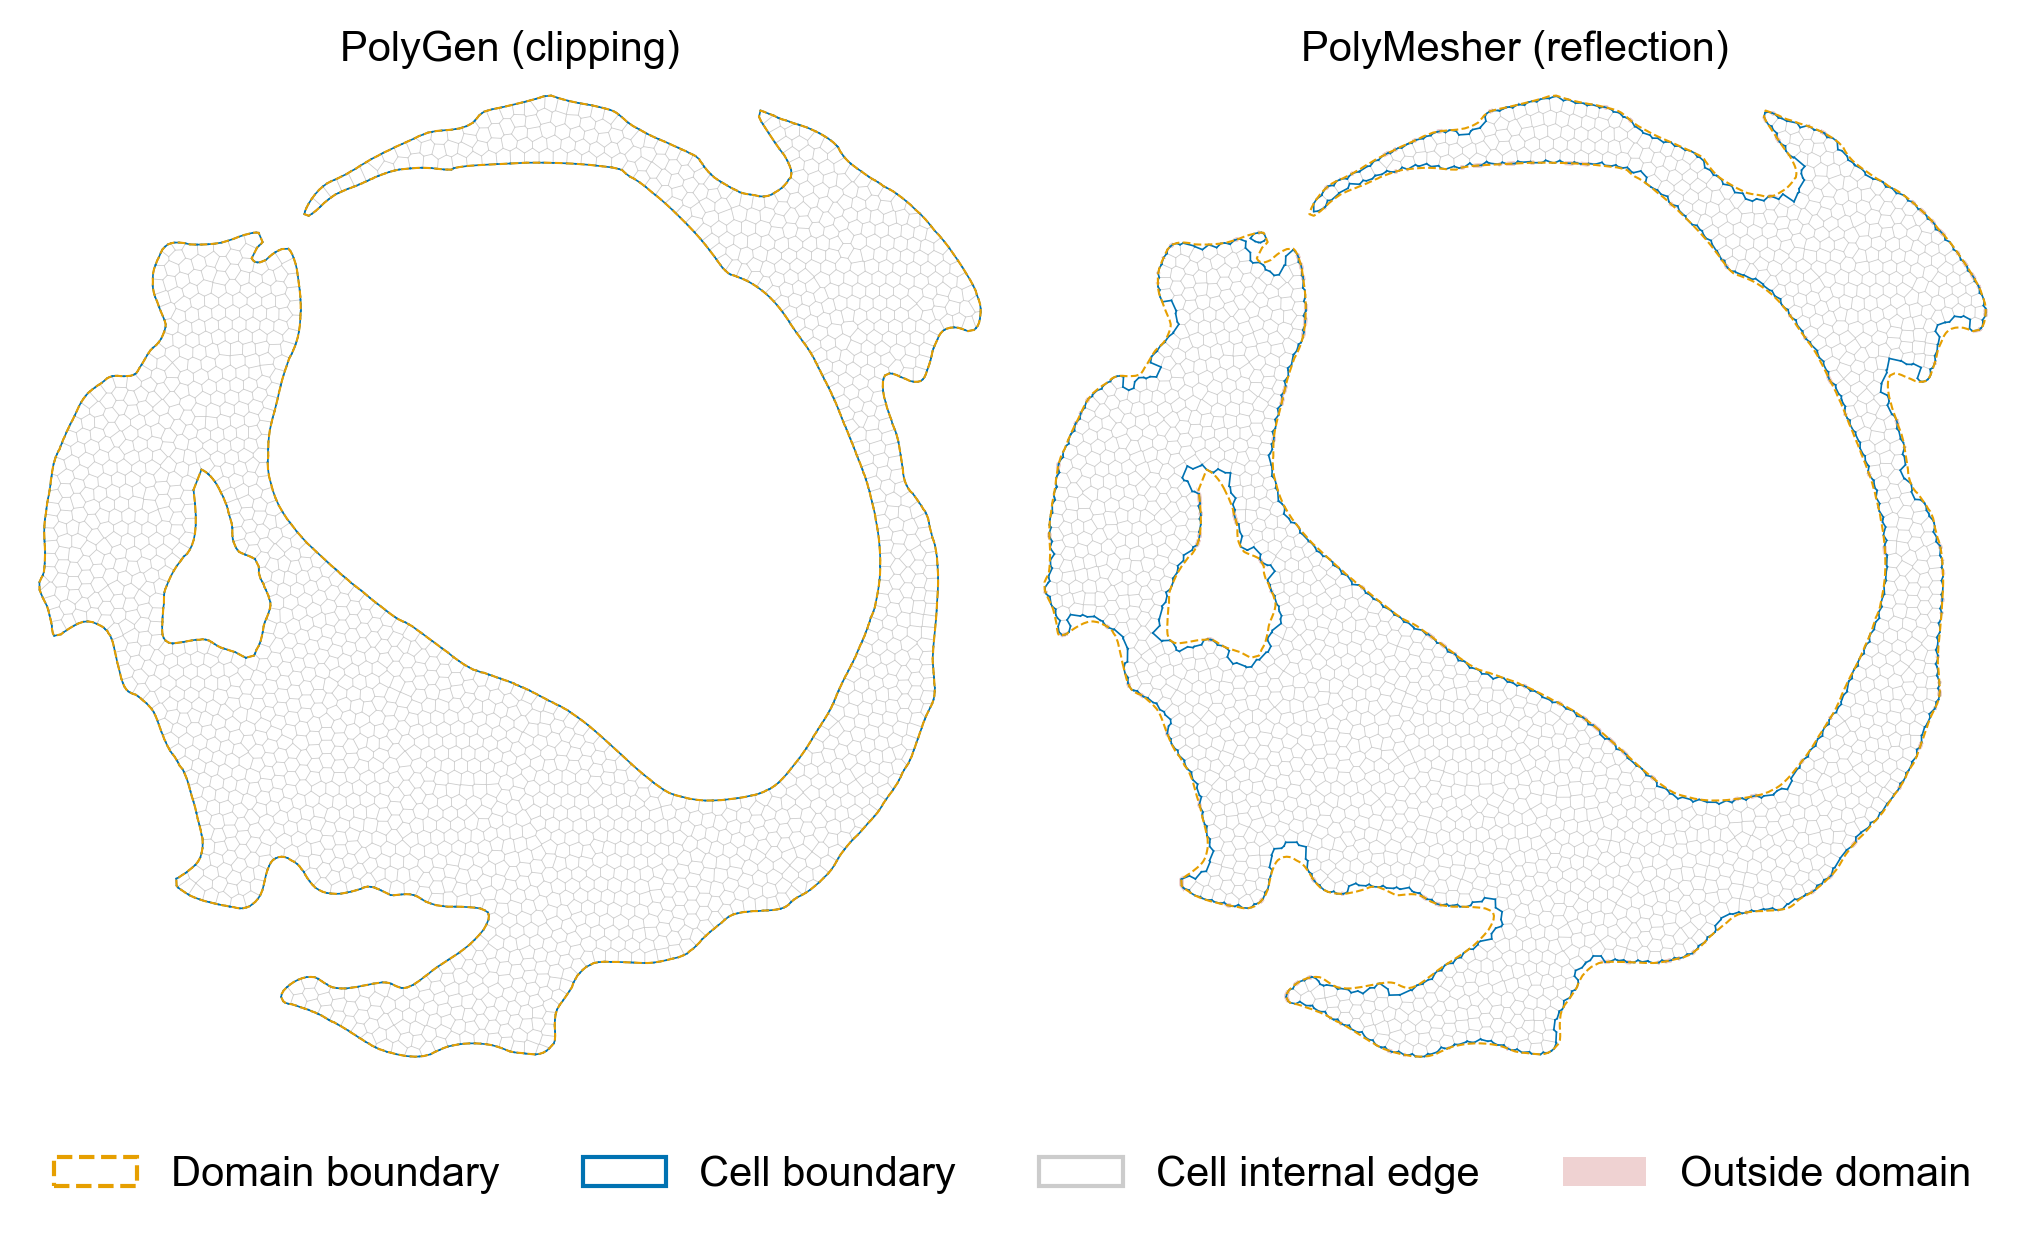

In [12]:
# Example usage
plot_boundary_comparison(
    domain=scaled_domain,
    polygen_cells=calcite_voronoi,
    polymesher_cells=polymesher_voronoi,
    figure_name="boundary_comparison.pdf",
    domain_color='#E69F00',  # Orange
    cell_boundary_color='#0072B2',  # Blue
    plot_all_cells=True,
    cell_internal_color='#CCCCCC',  # Light gray for internal edges
    domain_line_width=0.5,  # Slightly thicker for domain boundary
    cell_boundary_line_width=0.4,
    highlight_regions=None,  # Example region - adjust to your domain
    output_dir="quality_comparison_results",
    dpi=2400
)